In [158]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 11 10:40:39 2016

@author: vlchaplin@gmail.com
"""

import h5py
import sys
import numpy as np
from scipy import io
from math import *;


import glob
from scipy.signal import hilbert as hilbert
import scipy.signal as scisig
import matplotlib.pyplot as plt
from matplotlib import image

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

In [329]:
simDir="/Users/vchaplin/Data/Verasonics/PSF_simulation/runs0706cw/"
simFiles=glob.glob(simDir + "*.mat")

outH5file="/Users/vchaplin/Data/Verasonics/PSF_simulation/PSF_point_0609.h5"


#%% load template file
file="/Users/vchaplin/Data/Verasonics/PSF_simulation/runs0706cw/simulation_Harm1200_x300_y300.mat"

matdict=io.loadmat(file,squeeze_me=True,struct_as_record=False)

#load data
pr_data=matdict['sensor_data'].p
p_final=matdict['sensor_data'].p_final

Nchan=pr_data.shape[0]
Nt=pr_data.shape[1]
dt=matdict['dt']
times = np.arange(0, Nt*dt,dt)
simDims = (matdict['Nx'], matdict['Ny'] )

In [349]:
d = matdict['d']

pitch=matdict['pitch']*matdict['d']

c0 = np.mean(matdict['medium'].sound_speed)

#target image space
ducer_width = pitch*Nchan

dx = 2e-4
dz = 2e-4
Nx = round(ducer_width/dx)
Nz = round(6.0e-2 /dz )


dx = d
dz = d
Nx = matdict['Ny']
Nz = matdict['Nx']


xpnts = np.linspace(-0.5,0.5,Nx)*Nx*dx
zpnts = np.linspace(0,1,Nz)*Nz*dz
#sensor positions
ux = (np.linspace(-0.5,0.5,Nchan)*Nchan + 0.5)*pitch


#image and resampling grids
ndZ,ndX,ndux = np.meshgrid(zpnts,xpnts,ux, indexing='ij')

distances = np.sqrt( (ndX-ndux)**2 + ndZ**2 )
delayinds = np.round( distances / (c0*dt)).astype(int)
inbounds3 = (delayinds <= Nt)
ii=np.nonzero(inbounds3)

#%% determine input sampling
PSFsourcePlacementMask = np.zeros(simDims,dtype=bool)
uniqZ = {}
uniqX = {}



# "x" in the sim file name maps to depth (z) dimension
#for fi in range(0,len(simFiles)):
#    matdict=io.loadmat(simFiles[fi],squeeze_me=True,struct_as_record=False,variable_names='sourceloc')
#    zk,xk=matdict['sourceloc'][[0,1]]
#    PSFsourcePlacementMask[zk,xk]=True
    
#    uniqZ["%d"%zk]=1
#    uniqX["%d"%xk]=1
#%% PSF

#npointsZ = len(uniqZ)
#npointsX = len(uniqX)

#large dimensionality, store as 32 bit
#PSF = np.zeros([npointsZ,npointsX,Nz,Nx],dtype=np.int32)

In [351]:
np.unravel_index(np.argmax(img),img.shape)

(296, 302)

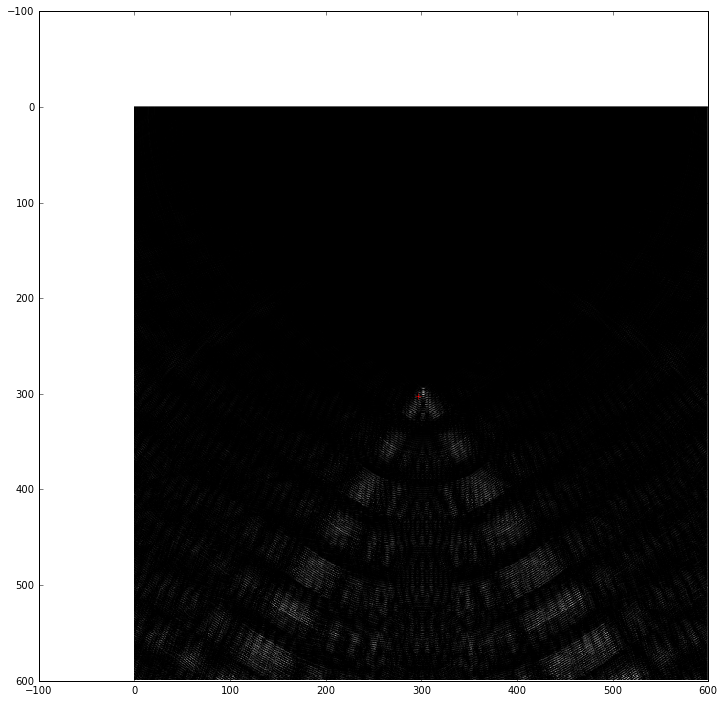

In [352]:
#%%image formation
delayed=np.zeros([Nz,Nx,Nchan])
delayed[ii[0],ii[1],ii[2]] = pr_data[ii[2], delayinds[inbounds3]]
img=np.sum(delayed*distances,axis=2)


chandelaysum = np.sum(distances*delayed,axis=2)
chandelaysum2 = np.sum( (distances*delayed)**2,axis=2) 
                
                
img = chandelaysum**2       

(z0i,x0j) = np.unravel_index(np.argmax(img),img.shape)

#%%plot
plt.figure(figsize=(12,12))
ext=[xpnts[0],xpnts[-1],zpnts[-1],zpnts[0]]
plt.imshow( img,cmap=image.cm.gray,interpolation='None')
plt.plot( [z0i],[x0j], 'r+')

In [353]:
(z0i,x0j) = np.unravel_index(np.argmax(img),img.shape)
PSFarray = img.copy()
def PSFij(z,x):
    row = np.floor( z/dz + z0i ).astype(int)
    col = np.floor( x/dx + x0j ).astype(int)
    
    return (row,col)

def PSF(z,x):
    (row,col) = PSFij(z,x)
    #if row<0 or row>=Nz:
    #    return 0
    #if col<0 or col>=Nx:
    #    return 0
    
    return PSFarray[row,col]
     


In [348]:
PSFij(0.01,0.01)

(319, 225)

In [347]:
PSFarray.shape

(300, 191)

In [179]:
blankarray = np.zeros([200, 100])
blankarray[50,10]=1
blankarray[120,40]=1

In [180]:
res = scisig.convolve2d(blankarray, PSFarray,mode='same')

In [181]:
res.shape

(200, 100)

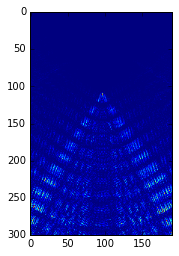

In [334]:
plt.imshow(PSFarray)

## Load PAM reconstruction (HDF5)

In [185]:
import h5py

def makename(case,power,probe,probestr=None):
    if probestr is None:
        probestr="probe%d"%probe
    
    return "%s/%s_%dW/%s"%(case,case,power,probestr)

def loadmaps( case,power, acqlist=None,h5f=f, timeavg=True):
    
        base=makename(case,power, 0)
    
        (nf,na,nz,nx)=h5f[base+'/cross'].shape
        Moment1Imgf=h5f[base+'/mom1'].value.reshape([2,nf*na,nz,nx])
        Moment2Imgf=h5f[base+'/mom2'].value.reshape([2,nf*na,nz,nx])
        ProbeCrossTerm = h5f[base+'/cross'].value.reshape([nf*na,nz,nx])
        
        if acqlist is None:
            varianceImage1 = Moment1Imgf[0]**2 - Moment2Imgf[0]
            varianceImage2 = Moment1Imgf[1]**2 - Moment2Imgf[1]
            coherenceTerm = 2*ProbeCrossTerm
        else:
            varianceImage1 = Moment1Imgf[0,acqlist]**2 - Moment2Imgf[0,acqlist]
            varianceImage2 = Moment1Imgf[1,acqlist]**2 - Moment2Imgf[1,acqlist]
            coherenceTerm = 2*ProbeCrossTerm[acqlist]
        if timeavg:
            varianceImage1 = np.mean(varianceImage1,axis=(0)) 
            varianceImage2 = np.mean(varianceImage2,axis=(0)) 
            coherenceTerm = np.mean(coherenceTerm,axis=(0)) 
            
        return (varianceImage1,varianceImage2,coherenceTerm)

In [324]:
hfile='/Users/Vandiver/Data/Verasonics/sonalleve_20160803/CoupledRecon_Chicken_20160803.h5'

hfile='/Users/Vandiver/Data/Verasonics/sonalleve_20160803/CoupledRecon_Phant_20160803.h5'

f = h5py.File(hfile,'r')

In [287]:
f.close()

In [375]:
(varianceImage1,varianceImage2,coherenceTerm) = loadmaps("multi_1",60,h5f=f,timeavg=True)

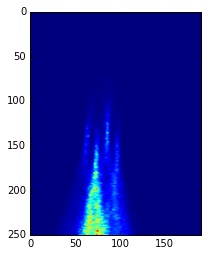

In [368]:
plt.imshow(varianceImage1)

### Richardson-Lucy

In [355]:
gz,gx=np.meshgrid(np.arange(-0.01,0.01,dz), np.arange(-0.01,0.01,dx), indexing='ij')
psf_h = PSF(gz,gx)
psf_hconj = PSF(-gz,-gx)



In [376]:
fn = varianceImage1.copy()

fnset=[]
for i in range(0,2):
    print(i)
    res = scisig.convolve2d(fn, psf_h,mode='same')
    fn1 = fn*scisig.convolve2d(fn/res, psf_hconj, mode='same')
    fnset.append(fn1)
    fn=fn1

0
1


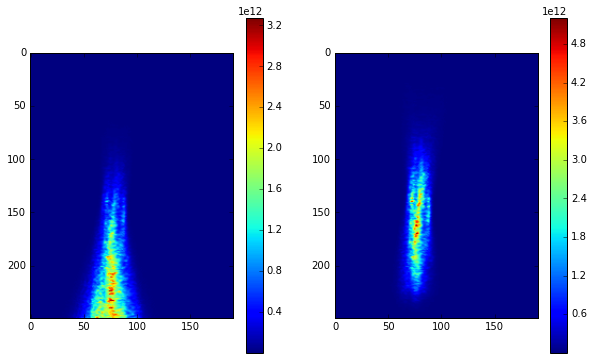

In [379]:
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(121)
im1=ax1.imshow(varianceImage1)
plt.colorbar(mappable=im1)
ax2=fig.add_subplot(122)
im2=ax2.imshow(fnset[1])
plt.colorbar(mappable=im2)

In [374]:
np.mean(varianceImage1)

42957802081.280563

In [373]:
np.mean(fnset[1])

45138200457.380402